<a href="https://colab.research.google.com/github/cc-ca/Human_action_understanding/blob/clip/Clip_Action_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO : 
- print only the name of the class
- calculate accuracy with validation test
- use more frame to predict the action

# Using CLIP to classify actions in video

This notebook presents classification of human's action in video based on CLIP zero-short transfer learning capabilities.



In [60]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Download and Install CLIP Dependencies



In [5]:
# installing some dependencies, CLIP was released in PyTorch
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch

print("Torch version:", torch.__version__)

CUDA version: 11.8
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 3.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.15.1 requires torch==2.0.0, 

In [6]:
# clone the CLIP repository
!git clone https://github.com/openai/CLIP.git

import sys
from pathlib import Path

clip_dir = Path(".").absolute() / "CLIP"
sys.path.append(str(clip_dir))
print(f"CLIP dir is: {clip_dir}")

import clip

Cloning into 'CLIP'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 8.92 MiB | 18.99 MiB/s, done.
Resolving deltas: 100% (124/124), done.
CLIP dir is: /content/CLIP


In [7]:
# Load pre-trained model
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)
print(f"Model dir: {os.path.expanduser('~/.cache/clip')}")

100%|███████████████████████████████████████| 338M/338M [00:15<00:00, 22.4MiB/s]


Model dir: /root/.cache/clip


# Class labels

We need class definitions for the classification task. Class definitions are provided as text that describe images. For example, `this is an image showing a cat`. Here, `cat` is our class of interest.

CLIP may be sensitive to use of words in text description. You may need to do your own experiments. Below I will show the effect of this.

Now we tokenize the text and calculate embeddings from tokens

# Prepare folders

In [8]:
if(not os.path.isdir('video')):
  os.mkdir('video')

if(not os.path.isdir('frames')):
  os.mkdir('frames')
  os.makedirs('frames/no_tag')

In [9]:
def deleteFrames():
  video_paths = os.listdir('./frames/no_tag/')
  for path in video_paths:
    os.remove('./frames/no_tag/'+path)


# Prepare images

We will consume images with the help of `ImageFolder` dataset from `PyTorch`.

In [10]:
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import cv2
import random
import tensorflow as tf
import numpy as np

In [11]:
# In order to display the image we will need to de-nonrmalize them
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).to('cpu')
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).to('cpu')

def denormalize_image(image: torch.Tensor) -> torch.Tensor:
    image *= image_std[:, None, None]    
    image += image_mean[:, None, None]
    return image

In [12]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [13]:
def frames_from_video_file(video_path, n_frames, output_size = (244,244), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [14]:
def convert(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  return converted_images

In [15]:
def sample_video(video_paths):
    sample_video = frames_from_video_file(str(video_paths), n_frames = 1)
    sample_video = convert(sample_video[0])
    img = Image.fromarray(sample_video, 'RGB')
    filePath = 'frames/no_tag/'+ str(random.randint(0,100000)) + ".jpg"
    img.save(filePath)

In [28]:
def show_results(image_features, text_features, class_names, dataset):
    # depends on global var dataset

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    k = np.min([len(class_names), 20])
    # top_probs, top_labels = text_probs.cpu().topk(k, dim=-1)
    text_probs = text_probs.cpu()

    plt.figure(figsize=(40, 25))

    for i, (image, label_idx) in enumerate(dataset):
        plt.subplot(8, 8, 2 * i + 1)
        plt.imshow(denormalize_image(image).permute(1, 2, 0))
        plt.axis("off")

        plt.subplot(8, 8, 2 * i + 2)
        y = np.arange(k)
        plt.grid()
        plt.barh(y, text_probs[i])
        plt.gca().invert_yaxis()
        plt.gca().set_axisbelow(True)
        # plt.yticks(y, [class_names[index] for index in top_labels[i].numpy()])
        plt.yticks(y, class_names)
        plt.xlabel("probability")

    plt.subplots_adjust(wspace=0.5)
    plt.show()
    

In [57]:
def predict_action(video_path, class_names):
  video_action_probs = list()
  for video in video_path:
    print("./video/"+video)
    sample_video("./video/"+video)
  folder_names = sorted(os.listdir('./frames/'))
  class_to_idx = {class_names[i]: i for i in range(len(folder_names))}
  class_captions = [f"An image depicting a {x}" for x in class_names]
  text_input = clip.tokenize(class_captions).to(device)
  #print(f"Tokens shape: {text_input.shape}")

  with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
  #print(f"Text features shape: {text_features.shape}")
  dataset = ImageFolder(root="./frames", transform=transform)
  data_batches = DataLoader(dataset, batch_size=len(dataset), shuffle=False) 

  image_input, y_true = next(iter(data_batches))
  image_input = image_input.to(device)

  with torch.no_grad():
    image_features = model.encode_image(image_input).float()


  
  text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  text_probs = np.array(text_probs.cpu())
  print(text_probs)
  for i in range(len(text_probs)):
    index_max = np.argmax(text_probs)
    #video_action_probs.append((video_path[i],class_names[index_max]))
    video_action_probs.append(class_names[index_max])
  show_results(image_features, text_features, class_names, dataset)  
  deleteFrames()
  return video_action_probs


In [41]:
class_names = ['applauding', 'cleaning toilet', 'doing nails', 'opening bottle', 'petting cat', 'pillow fight', 'playing cards', 'playing guitar', 'smoking', 'stretching arm', 'vacuuming floor', 'washing dishes', 'archery']

./video/_95YkRf4SS4_000209_000219.mp4
./video/_sUJUek9OZM_000023_000033.mp4
[[6.77742922e-21 6.67823222e-15 3.31226950e-19 7.31243244e-27
  1.00000000e+00 2.71691493e-14 3.44700347e-33 1.13988957e-31
  4.03037556e-23 1.01927935e-16 4.03266523e-24 2.84790841e-23
  1.21970794e-24]
 [1.79688502e-41 0.00000000e+00 6.62717036e-38 0.00000000e+00
  1.00000000e+00 2.09161108e-29 3.37712930e-43 0.00000000e+00
  3.64337601e-44 2.51382385e-25 0.00000000e+00 1.21912966e-43
  0.00000000e+00]]


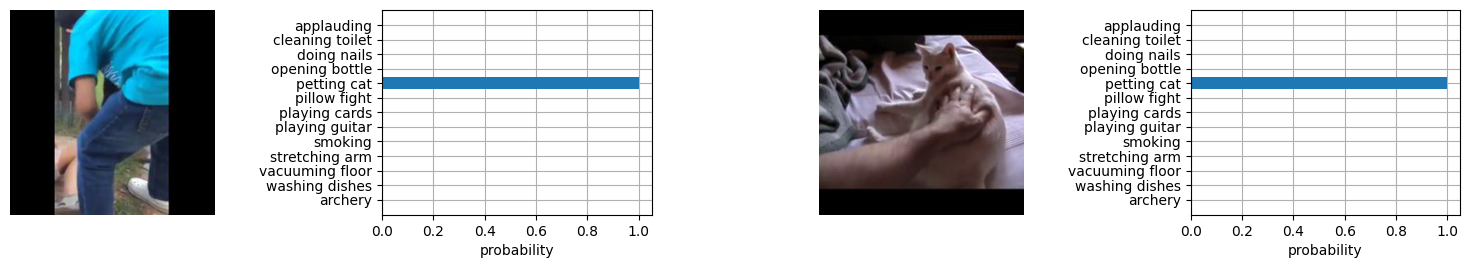

In [58]:
video_names = sorted(os.listdir('./video/'))

if(len(video_names) != 0):
  if(video_names[0] == ".ipynb_checkpoints"):
    video_names.pop(0)
  try:
    video_action_probs = predict_action(video_names, class_names)
  except:
    print("Incorrect files or Error during prediction !")

else:
  print("The folder video is empty. Upload inside video(s) you want to predict !")

In [59]:
print(video_action_probs)

['petting cat', 'petting cat']


In [69]:
#Create dictionnary where key is the class name and value is a list with the name of the video in this class

val_dataset = dict() 
for class_name in class_names:
  val_dataset[class_name] = sorted(os.listdir('/content/drive/MyDrive/dataset/val/applauding'))


# Perform classification

Let's perform the classification with our out of the box labels.

In [ ]:
# read out all images and true labels
image_input, y_true = next(iter(data_batches))
image_input = image_input.to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()


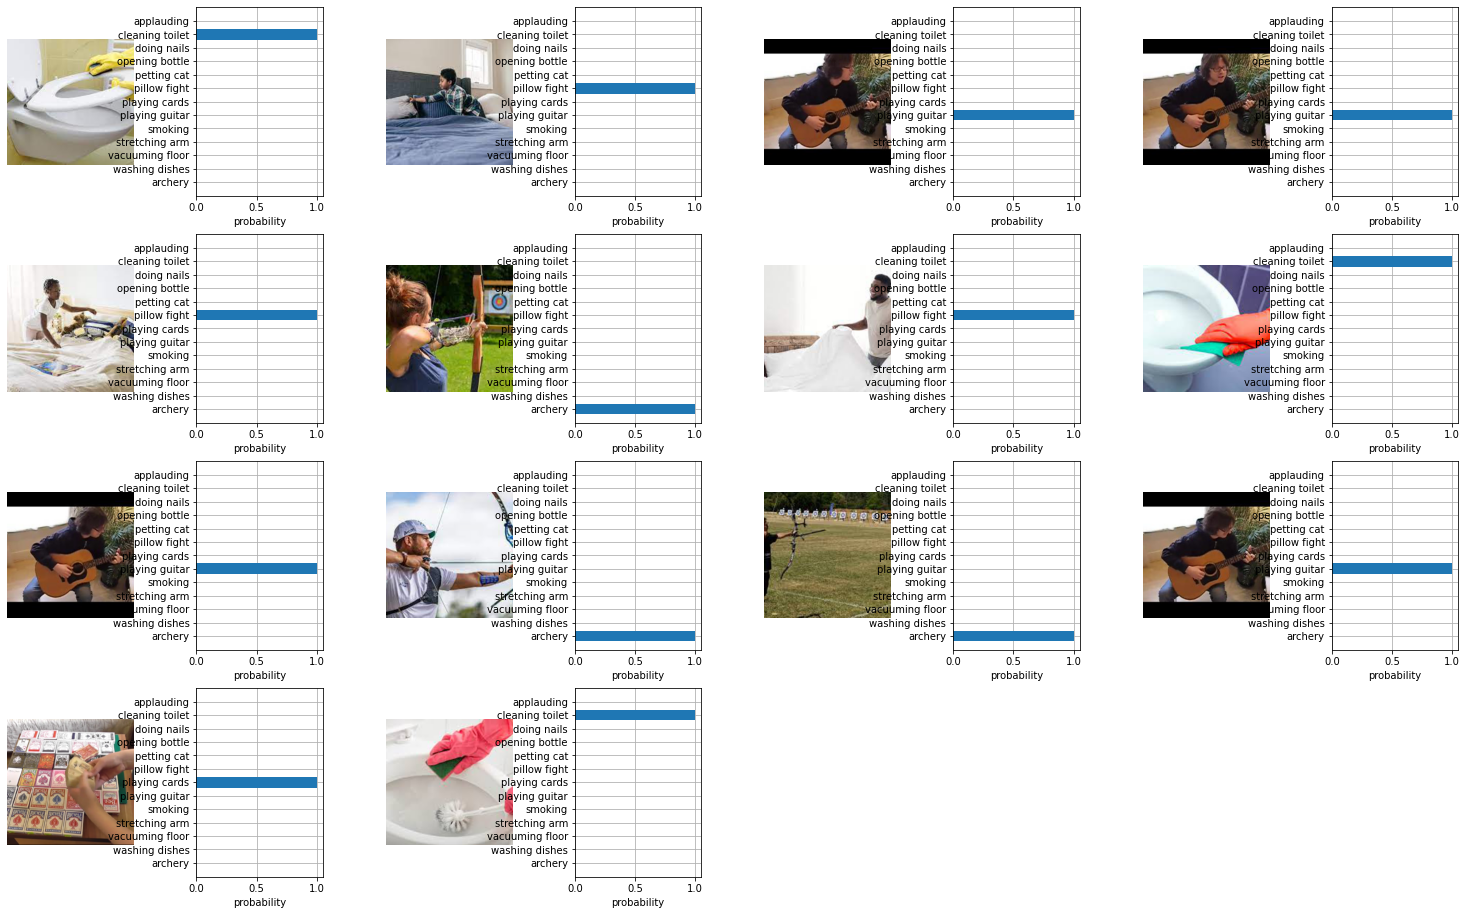

In [ ]:
show_results(image_features, text_features, class_names)

You can see that CLIP is not doing great with these labels.

Let's play with the labels a bit and see if it changes anything.